# Load calculated values and plot the statistics for MSD-dT
This notebook reproduces Fig.11(a) for the following manuscript:

Yi, X., Miao, H., Lo, J.K.Y., Elsheikh, M., Lee, T.H., Jiang, C., Segelke, B.W., Overton, K.W., Bremer, P.T. and Laurence, T.A., 2022. A Tailored Approach To Study Legionella Infection Using Lattice Light Sheet Microscope (LLSM). bioRxiv. doi: https://doi.org/10.1101/2022.03.20.485032

### Datasets can be downloaded from the following data repository on figshare:
 Yi, Xiyu; Miao, Haichao; Lo, Jacky Kai-Yin; Elsheikh, Maher M.; Lee, Tek Hyung; Jiang, Chenfanfu; et al. (2022): Datasets for the manuscript titled "A Tailored Approach to Study Legionella Infection Using Lattice Light Sheet Microscope (LLSM)". figshare. Journal contribution. https://doi.org/10.6084/m9.figshare.19694809.v30 

### llsmvis repository can be found here:
https://github.com/xiyuyi-at-LLNL/llsmvis

# 1. Import tools

In [22]:
import sys
# append the directory to llsmvis to the system path following the examples below.
sys.path.append('/g/g92/miao1/Development/llsmvis')
sys.path.append('/Users/yi10/Desktop/Research/Software/T-llsmvis/')
sys.path.append('/g/g92/yi10')
sys.path.append('[add your path to the llsmvis folder]')

import llsmvis
from llsmvis.extensions import hp3d
from llsmvis.extensions.hp3d import surface_morphometrics as sm
from llsmvis.extensions.hp3d import masscenter as mc
from llsmvis.extensions.hp3d import croproi3d as c3d
from llsmvis.extensions.hp3d import tools_writeout as tools
import h5py
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util import numpy_support
from llsmvis.extensions.hp3d import tools_vectorsets as v
from scipy.interpolate import griddata
import copy
from scipy.stats import pearsonr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Aggregate datasets into 2 conditions (naive and infected macrophages)

In [23]:
fpaths=[x for x in os.listdir('/p/lscratchh/yi10/hp3d') if x.startswith('2021')] # change this path to your local data path.
# separate fpaths into 2 groups, one is naive macrophage, the other one is infected macrophage.
fpaths_naive_macr=[]
fpaths_Lg_macr_cl=[]

for i, fpath in enumerate(fpaths):
    if fpath.startswith('2021-09-'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-01'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-04'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-06'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-08'):
        fpaths_naive_macr.append(fpath)
    
    if fpath.startswith('2021-10-14'):
        fpaths_naive_macr.append(fpath)
        
    
    if fpath.startswith('2021-10-28'):
        fpaths_Lg_macr_cl.append(fpath)
    
    if fpath.startswith('2021-10-29'):
        fpaths_Lg_macr_cl.append(fpath)
    
    if fpath.startswith('2021-11-'):
        fpaths_Lg_macr_cl.append(fpath)

print(str(len(fpaths_naive_macr))+' naive macrophage cells')
print(str(len(fpaths_Lg_macr_cl))+' infected macrophage cells')



131 naive macrophage cells
101 infected macrophage cells


# 3. Load values

In [24]:
# plot polarity vector amplitude evolution per cell, and append it to the cell hdf5
# fpath=fpaths_naive_macr[0]

def load_volume_centers_center_shifted(fpath, showplot=False):
    cell_hdf5_path='/p/lscratchh/yi10/hp3d/'+fpath+'/hp3ddata_'+fpath+'.hdf5' # change this path to your local data path.
    print('loading '+cell_hdf5_path)
    f2 = h5py.File(cell_hdf5_path, 'r')
    v0=np.asarray(f2['[D9] volume centers'])    
    v=v0-v0[0,:]
    return v
        

# 4. Check the data fields

You can change the corresponding datapath to your own path


In [25]:
fpath=fpaths[0]
cell_hdf5_path='/p/lscratchh/yi10/hp3d/'+fpath+'/hp3ddata_'+fpath+'.hdf5'# change this path to your local data path.
f2 = h5py.File(cell_hdf5_path, 'a')
for a in f2.keys():
    print(a)
f2.close()

[D10] volume values
[D11] surface area values
[D12] sphere radius with equi volume
[D13] sphere radius with equi surface area
[D14] polarity vector amplitudes
[D15] polarity based on volume - negative volume std
[D16] polarity based on volume - positive volume std
[D17] polarity based on volume - sum of negative delta volumes
[D18] polarity based on volume - sum of positive delta volumes
[D19] polarity based on roughness - maxima N
[D1] mass centers
[D20] polarity based on roughness - minima N
[D2] threshold saddle point
[D3] threshold saddle point index
[D4] threshold upper bound
[D5] threshold upper bound index
[D6] threshold lower bound
[D7] threshold lower bound index
[D8] threshold cell peripheral lower bound
[D9] volume centers
[G01] voxel value bin centers
[G02] voxel value histogram counts
[G03] stack XY mips before cropping
[G04] stack YZ mips before cropping
[G05] stack XZ mips before cropping
[G06] stack XY mips after cropping - saddle point to upper bound
[G07] stack YZ mip

# 5. Organize the data valuse over all datasets

In [26]:
import copy

In [27]:
vs=load_volume_centers_center_shifted(fpath, showplot=False)

loading /p/lscratchh/yi10/hp3d/2021-11-04-cell7/hp3ddata_2021-11-04-cell7.hdf5


In [28]:
vs.shape

(50, 3)

In [29]:
# organize for naive macrophage cells

tag=0
l=[]
for fpath in fpaths_naive_macr:
    try:
        vs=load_volume_centers_center_shifted(fpath, showplot=False)
        l.append(vs)    
        tag+=1
    except:
        pass

values_for_naive_macrophage=copy.deepcopy(l)

loading /p/lscratchh/yi10/hp3d/2021-09-24-cell7/hp3ddata_2021-09-24-cell7.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-14-cell1/hp3ddata_2021-10-14-cell1.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-14-cell16/hp3ddata_2021-10-14-cell16.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-01-cell5/hp3ddata_2021-10-01-cell5.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-24-cell16/hp3ddata_2021-09-24-cell16.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-30-cell4/hp3ddata_2021-09-30-cell4.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell4/hp3ddata_2021-10-04-cell4.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-22-cell20/hp3ddata_2021-09-22-cell20.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell12/hp3ddata_2021-10-04-cell12.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell18/hp3ddata_2021-10-04-cell18.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-29-cell0/hp3ddata_2021-09-29-cell0.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-30-cell11/hp3ddata_2021-09-30-cell11.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-0

loading /p/lscratchh/yi10/hp3d/2021-09-24-cell2/hp3ddata_2021-09-24-cell2.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-27-cell6/hp3ddata_2021-09-27-cell6.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-08-cell1/hp3ddata_2021-10-08-cell1.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell25/hp3ddata_2021-10-04-cell25.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-30-cell1/hp3ddata_2021-09-30-cell1.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-22-cell25/hp3ddata_2021-09-22-cell25.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell1/hp3ddata_2021-10-04-cell1.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell17/hp3ddata_2021-10-04-cell17.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-29-cell5/hp3ddata_2021-09-29-cell5.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-06-cell2/hp3ddata_2021-10-06-cell2.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell6/hp3ddata_2021-10-04-cell6.hdf5
loading /p/lscratchh/yi10/hp3d/2021-09-29-cell8/hp3ddata_2021-09-29-cell8.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-04-cell

In [30]:
# organize for infected macrophage cells
tag=0
l=[];
for fpath in fpaths_Lg_macr_cl:
    try:
        vs=load_volume_centers_center_shifted(fpath, showplot=False)
        l.append(vs)    
        tag+=1
    except:
        pass
values_for_Lg_macrophage=copy.deepcopy(l)

loading /p/lscratchh/yi10/hp3d/2021-11-04-cell7/hp3ddata_2021-11-04-cell7.hdf5
loading /p/lscratchh/yi10/hp3d/2021-10-28-cell3/hp3ddata_2021-10-28-cell3.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-02-cell2/hp3ddata_2021-11-02-cell2.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-11-cell3/hp3ddata_2021-11-11-cell3.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-11-cell9/hp3ddata_2021-11-11-cell9.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-17-cell6/hp3ddata_2021-11-17-cell6.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-09-cell0/hp3ddata_2021-11-09-cell0.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-12-cell7/hp3ddata_2021-11-12-cell7.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-10-cell4/hp3ddata_2021-11-10-cell4.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-09-cell12/hp3ddata_2021-11-09-cell12.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-11-cell10/hp3ddata_2021-11-11-cell10.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-04-cell12/hp3ddata_2021-11-04-cell12.hdf5
loading /p/lscratchh/yi10/hp3d/2021-11-05-cell

In [31]:
# simplify variables
v1 = values_for_naive_macrophage
v2 = values_for_Lg_macrophage

In [32]:
np.asarray(v1).shape

(131, 50, 3)

In [33]:
np.asarray(v2).shape

(101, 50, 3)

# 6. Get mean square displacement as compared to the starting point

In [34]:
# try to get mean square displacement
MSD_naive = []
MSD_infec = []

MSD_naive_std = []
MSD_infec_std = []

for ti in np.arange(50):
    MSD_naive.append(np.mean(np.asarray(v1)[:,ti,:]**2, axis=0))
    MSD_infec.append(np.mean(np.asarray(v2)[:,ti,:]**2, axis=0))
    MSD_naive_std.append(np.std(np.asarray(v1)[:,ti,:]**2, axis=0))
    MSD_infec_std.append(np.std(np.asarray(v2)[:,ti,:]**2, axis=0))

MSD_naive = np.asarray(MSD_naive)
MSD_infec = np.asarray(MSD_infec)
MSD_naive_SE = np.asarray(np.sum(MSD_naive_std, axis=1))/np.sqrt(131)
MSD_infec_SE = np.asarray(np.sum(MSD_infec_std, axis=1))/np.sqrt(101)


# Plot

<Figure size 288x288 with 0 Axes>

Text(0.5, 1.0, 'MSD - dT curve')

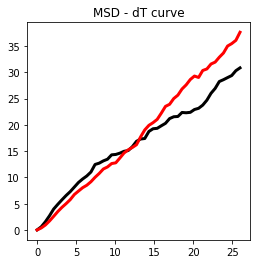

In [35]:
plt.figure(figsize=(4, 4))

msdn = np.sum(MSD_naive, axis=1); # sum over x,y,z dimensions
msdi = np.sum(MSD_infec, axis=1); # sum over x,y,z dimensions

msdn = msdn/100 # convert unit (1 pixel size is 100 nm, original unit was pixel-width square, convert to um2)
msdi = msdi/100 



plt.plot(np.arange(50)/49*26, msdn, 'k-', linewidth=3) # total time points=50, average total time course is 26 min
plt.plot(np.arange(50)/49*26, msdi, 'r-', linewidth=3) # total time points=50, average total time course is 26 min

# y1a=msdn-MSD_naive_SE
# y1b=msdn+MSD_naive_SE
# plt.fill_between(np.arange(50)/49*26, y1a, y1b, 
#              color='k',alpha=0.2)

# y1a=msdi-MSD_infec_SE
# y1b=msdi+MSD_infec_SE
# plt.fill_between(np.arange(50)/49*26, y1a, y1b, 
#              color='r',alpha=0.2)

plt.title('MSD - dT curve')

# 7. get MSD per trajectory then take the average of MSD

In [44]:
def get_MSD(traj):
    MSD=np.arange(49)*0
    for i0 in np.arange(49)+1:
        traj1 = traj[:-i0, :]
        traj2 = traj[i0:, :]
        MSD[i0-1] = np.mean(np.sum((traj2 - traj1)**2,axis=1))/100 # divide by 100 is to convert the unit to um**2. Pixel size was 100 nm.
    return MSD

def get_indiv_MSDs_for_give_lag(traj,lag):
        traj1 = traj[:-i0, :]
        traj2 = traj[i0:, :]
        msds=np.sum((traj2 - traj1)**2,axis=1)/100 # divide by 100 is to convert the unit to um**2. Pixel size was 100 nm.
    return msds


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 13)

In [37]:
MSDs_naive=[]
MSDs_infec=[]
for ti in np.arange(131):
    print('naive traj #' +str(ti))
    MSDs_naive.append(get_MSD(np.asarray(v1)[ti,:,:]))

for ti in np.arange(101):
    print('infected traj #' +str(ti))
    MSDs_infec.append(get_MSD(np.asarray(v2)[ti,:,:]))


naive traj #0
naive traj #1
naive traj #2
naive traj #3
naive traj #4
naive traj #5
naive traj #6
naive traj #7
naive traj #8
naive traj #9
naive traj #10
naive traj #11
naive traj #12
naive traj #13
naive traj #14
naive traj #15
naive traj #16
naive traj #17
naive traj #18
naive traj #19
naive traj #20
naive traj #21
naive traj #22
naive traj #23
naive traj #24
naive traj #25
naive traj #26
naive traj #27
naive traj #28
naive traj #29
naive traj #30
naive traj #31
naive traj #32
naive traj #33
naive traj #34
naive traj #35
naive traj #36
naive traj #37
naive traj #38
naive traj #39
naive traj #40
naive traj #41
naive traj #42
naive traj #43
naive traj #44
naive traj #45
naive traj #46
naive traj #47
naive traj #48
naive traj #49
naive traj #50
naive traj #51
naive traj #52
naive traj #53
naive traj #54
naive traj #55
naive traj #56
naive traj #57
naive traj #58
naive traj #59
naive traj #60
naive traj #61
naive traj #62
naive traj #63
naive traj #64
naive traj #65
naive traj #66
naive

In [38]:
MSDs_naive=np.asarray(MSDs_naive)
MSDs_infec=np.asarray(MSDs_infec)


In [39]:
MSDs_naive.shape

(131, 49)

In [40]:
MSDs_infec.shape


(101, 49)

In [41]:
t=np.arange(50)/49*26
y1=np.zeros(50)
y1[1:]=np.mean(MSDs_naive,axis=0)

std1=np.zeros(50)
std1[1:]=np.std(MSDs_naive,axis=0)/np.sqrt(131)
y1a=y1-std1
y1b=y1+std1

y2=np.zeros(50)
y2[1:]=np.mean(MSDs_infec,axis=0)
std2=np.zeros(50)
std2[1:]=np.std(MSDs_infec,axis=0)/np.sqrt(101)
y2a=y2-std2
y2b=y2+std2


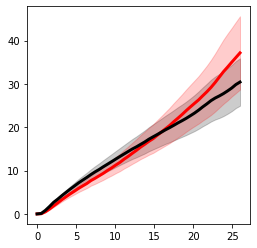

In [42]:
fig=plt.figure(figsize=(4,4))

plt.fill_between(t, y1a, y1b, 
             color='k',alpha=0.2)

plt.fill_between(t, y2a, y2b, 
             color='r',alpha=0.2)

plt.plot(t, y2,'r', linewidth=3)
plt.plot(t, y1,'k', linewidth=3)

fig.savefig('MSD-dT.png',dpi=300)

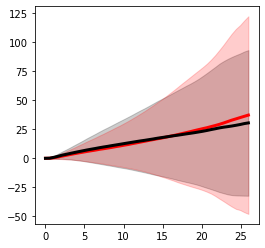

In [92]:
t=np.arange(50)/49*26
y1=np.zeros(50)
y1[1:]=np.mean(MSDs_naive,axis=0)

std1=np.zeros(50)
std1[1:]=np.std(MSDs_naive,axis=0)
y1a=y1-std1
y1b=y1+std1

y2=np.zeros(50)
y2[1:]=np.mean(MSDs_infec,axis=0)
std2=np.zeros(50)
std2[1:]=np.std(MSDs_infec,axis=0)
y2a=y2-std2
y2b=y2+std2

fig=plt.figure(figsize=(4,4))

plt.fill_between(t, y1a, y1b, 
             color='k',alpha=0.2)

plt.fill_between(t, y2a, y2b, 
             color='r',alpha=0.2)

plt.plot(t, y2,'r', linewidth=3)
plt.plot(t, y1,'k', linewidth=3)

fig.savefig('MSD-dT-std-e-range.png',dpi=300)